[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/wilsonhoyos1/Proyecto_Reconocimiento_Ocular_Enfermedades/blob/main/02_prediccion.ipynb)

In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = "wilsonhoyosbenavides" # username from the json file
os.environ['KAGGLE_KEY'] = "dcca300220865f6af4b2f59796b16b35" # key from the json file
!kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k #database to work on

100% 1.62G/1.62G [00:14<00:00, 129MB/s]
100% 1.62G/1.62G [00:14<00:00, 119MB/s]


In [ ]:
!mkdir ocular_diseases
!unzip ocular-disease-recognition-odir5k.zip -d ocular_diseases

Se truncaron las últimas líneas 5000 del resultado de transmisión.
  inflating: ocular_diseases/preprocessed_images/2179_left.jpg  
  inflating: ocular_diseases/preprocessed_images/2179_right.jpg  
  inflating: ocular_diseases/preprocessed_images/217_left.jpg  
  inflating: ocular_diseases/preprocessed_images/217_right.jpg  
  inflating: ocular_diseases/preprocessed_images/2180_left.jpg  
  inflating: ocular_diseases/preprocessed_images/2180_right.jpg  
  inflating: ocular_diseases/preprocessed_images/2181_left.jpg  
  inflating: ocular_diseases/preprocessed_images/2181_right.jpg  
  inflating: ocular_diseases/preprocessed_images/2182_left.jpg  
  inflating: ocular_diseases/preprocessed_images/2182_right.jpg  
  inflating: ocular_diseases/preprocessed_images/2183_left.jpg  
  inflating: ocular_diseases/preprocessed_images/2183_right.jpg  
  inflating: ocular_diseases/preprocessed_images/2184_left.jpg  
  inflating: ocular_diseases/preprocessed_images/2184_right.jpg  
  inflating: ocula

In [ ]:
!pip install openpyxl

import numpy as np 
import pandas as pd
import os
import random
import itertools
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img,img_to_array

from keras.utils import np_utils
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Reshape, Dropout
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping


## models to import
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
df_data = pd.read_csv("ocular_diseases/full_df.csv")
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6392 entries, 0 to 6391
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ID                         6392 non-null   int64 
 1   Patient Age                6392 non-null   int64 
 2   Patient Sex                6392 non-null   object
 3   Left-Fundus                6392 non-null   object
 4   Right-Fundus               6392 non-null   object
 5   Left-Diagnostic Keywords   6392 non-null   object
 6   Right-Diagnostic Keywords  6392 non-null   object
 7   N                          6392 non-null   int64 
 8   D                          6392 non-null   int64 
 9   G                          6392 non-null   int64 
 10  C                          6392 non-null   int64 
 11  A                          6392 non-null   int64 
 12  H                          6392 non-null   int64 
 13  M                          6392 non-null   int64 
 14  O       

In [ ]:
img_dir = "ocular_diseases/preprocessed_images"

CATARACT IMAGES

In [ ]:
df_left_cat = df_data[df_data['Left-Diagnostic Keywords'].str.match('cataract')]
df_right_cat = df_data[df_data['Right-Diagnostic Keywords'].str.match('cataract')]

In [ ]:
df_filenames_cat = df_left_cat['Left-Fundus'].append(df_right_cat['Right-Fundus'], ignore_index=True)
display(df_filenames_cat.head())
display(df_filenames_cat.tail())

0      0_left.jpg
1    103_left.jpg
2    119_left.jpg
3    254_left.jpg
4    294_left.jpg
dtype: object

567    2243_right.jpg
568    2246_right.jpg
569    2247_right.jpg
570    2248_right.jpg
571    2282_right.jpg
dtype: object

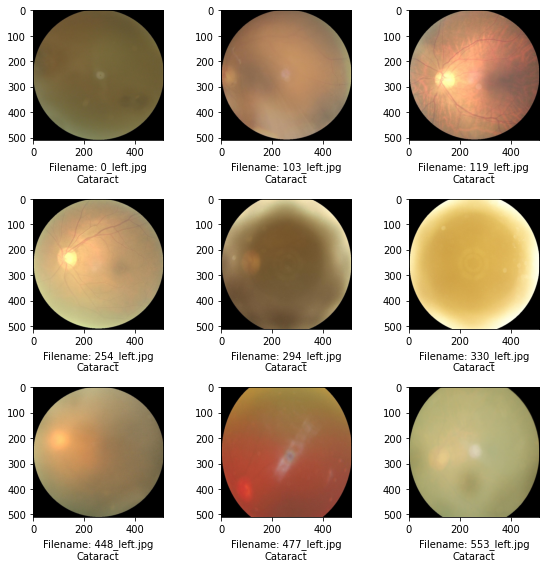

In [ ]:
plt.figure(figsize=(8,8))
for i in range(9):
    img = df_filenames_cat[i]
    image = cv2.imread(os.path.join(img_dir, img))

    ## convert image to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    ## subplot variables - (# of rows, # of columns, iterate through locations on grid)
    plt.subplot(3,3,i+1)
    plt.imshow(image_rgb)
    
    ## label with filename and diagnosis
    plt.xlabel('Filename: {}\n''Cataract'.format(df_filenames_cat[i]))

plt.tight_layout() 

NORMAL IMAGES

In [ ]:
df_left_normal = df_data[df_data['Left-Diagnostic Keywords'].str.match('normal')]
df_right_normal = df_data[df_data['Right-Diagnostic Keywords'].str.match('normal')]

In [ ]:
df_filenames_normal = df_left_normal['Left-Fundus'].append(df_right_normal['Right-Fundus'], ignore_index=True)
display(df_filenames_normal.head())
display(df_filenames_normal.tail())

0     1_left.jpg
1     8_left.jpg
2     9_left.jpg
3    14_left.jpg
4    15_left.jpg
dtype: object

5585    4642_right.jpg
5586    4644_right.jpg
5587    4660_right.jpg
5588    4671_right.jpg
5589    4689_right.jpg
dtype: object

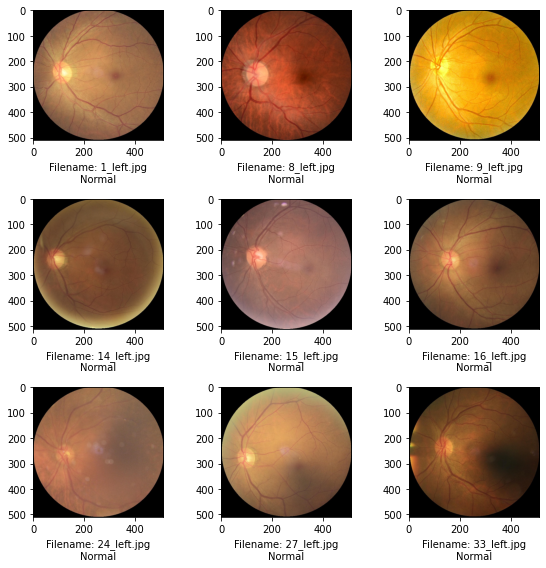

In [ ]:
plt.figure(figsize=(8,8))
for i in range(9):
    img = df_filenames_normal[i]
    image = cv2.imread(os.path.join(img_dir, img))

    ## convert image to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    ## subplot variables - (# of rows, # of columns, iterate through locations on grid)
    plt.subplot(3,3,i+1)
    plt.imshow(image_rgb)
    
    ## label with filename and diagnosis
    plt.xlabel('Filename: {}\n''Normal'.format(df_filenames_normal[i]))

plt.tight_layout() 

COMPARING CATARACT VS. NORMAL


In [ ]:
df_filenames_cat = pd.DataFrame(df_filenames_cat, columns = ["filename"])
df_filenames_cat["label"] = "cataract"
df_filenames_cat.tail()

,filename,label
567,2243_right.jpg,cataract
568,2246_right.jpg,cataract
569,2247_right.jpg,cataract
570,2248_right.jpg,cataract
571,2282_right.jpg,cataract


In [ ]:
df_filenames_normal_random = df_filenames_normal.sample(n = 572)

In [ ]:
df_filenames_normal_random = pd.DataFrame(df_filenames_normal_random, columns = ["filename"])
df_filenames_normal_random["label"] = "normal"
df_filenames_normal_random.tail()

,filename,label
3915,3171_right.jpg,normal
3939,3195_right.jpg,normal
4840,2707_right.jpg,normal
541,2640_left.jpg,normal
1496,425_left.jpg,normal


In [ ]:
df_combined = df_filenames_cat.append(df_filenames_normal_random, ignore_index=True)
df_combined_random = df_combined.sample(frac=1).reset_index(drop=True)
df_combined_random

,filename,label
0,2411_right.jpg,normal
1,2074_right.jpg,cataract
2,2101_left.jpg,cataract
3,2150_right.jpg,cataract
4,2531_right.jpg,normal
...,...,...
1139,3110_left.jpg,normal
1140,2760_left.jpg,normal
1141,2107_left.jpg,cataract
1142,2160_right.jpg,cataract


TRAIN_TEST_VAL

In [ ]:
df_train = df_combined_random.sample(frac=0.8,random_state=42)
df_train.reset_index(drop=True)

# exclude the 80% that was already chosen, the remaining 20% will go into testing
df_test = df_combined_random.drop(df_train.index)
df_test.reset_index(drop=True)

print(len(df_combined_random))
print(len(df_train))
print(len(df_test))

1144
915
229


In [ ]:
img_size = 224
train_datagen=tf.keras.preprocessing.image.ImageDataGenerator(
            rescale=1./255.,
            validation_split=0.20,
            rotation_range=90,
#            width_shift_range=0.2,
#            height_shift_range=0.2,
            horizontal_flip=True,
            vertical_flip=True,
            shear_range=0.2,
            brightness_range=[0.3,1]    
#            zoom_range=0.2
            )
test_datagen=ImageDataGenerator(rescale=1./255.)

In [ ]:
df_train['label'] = df_train['label'].astype(str)
df_test['label'] = df_test['label'].astype(str)

In [ ]:
train_generator=train_datagen.flow_from_dataframe(
dataframe=df_train,
directory=img_dir,
x_col="filename",
y_col="label",
subset="training",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(img_size,img_size))

## validation set is created from the training set, 
## we set it at 20% of the training data in the previous code

valid_generator=train_datagen.flow_from_dataframe(
dataframe=df_train,
directory=img_dir,
x_col="filename",
y_col="label",
subset="validation",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(img_size,img_size))



test_generator=test_datagen.flow_from_dataframe(
dataframe=df_test,
directory=img_dir,
x_col="filename",
y_col="label",
batch_size=32,
#seed=42,
shuffle=False,
class_mode="categorical",
target_size=(img_size,img_size))

Found 732 validated image filenames belonging to 2 classes.
Found 183 validated image filenames belonging to 2 classes.
Found 229 validated image filenames belonging to 2 classes.


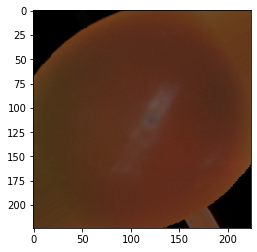

In [ ]:
train_image_data, train_labels = train_generator.next()
train_image_data.shape
plt.imshow(train_image_data[0], interpolation='nearest')
plt.show()

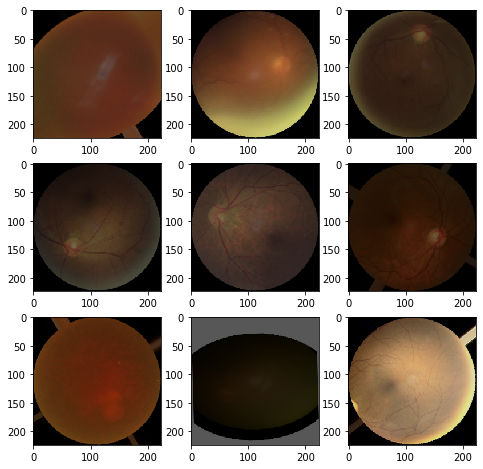

In [ ]:
plt.figure(figsize=(8,8))

for i in range(9):
    plt.subplot(3, 3, i + 1) 
    plt.imshow(train_image_data[i], interpolation='nearest')
    
plt.show() 

In [ ]:
vgg16 = keras.applications.vgg16.VGG16(input_shape=(224, 224, 3),
                                       weights='imagenet',
                                       include_top=False)

# add new dense layers at the top
x = keras.layers.Flatten()(vgg16.output)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(128, activation='relu')(x)

## remember we are using 2 outputs only
predictions = keras.layers.Dense(2, activation='softmax')(x)

# define and compile model
model = keras.Model(inputs=vgg16.inputs, outputs=predictions)
for layer in vgg16.layers:
    layer.trainable = False
    
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

58889256/58889256 [==============================] - 2s 0us/step


In [ ]:
checkpoint = ModelCheckpoint("vgg16_1.h5", 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False, 
                             mode='auto', 
                             period=1)

early = EarlyStopping(monitor='val_accuracy', 
                      min_delta=0, 
                      patience=3, 
                      verbose=1, 
                      mode='auto')

In [ ]:
batch_size = 32
n_spe = train_generator.samples // batch_size
n_val_steps = valid_generator.samples // batch_size
n_epochs = 30

print(n_spe,n_val_steps)

22 5


In [ ]:
hist = model.fit(train_generator,
                        steps_per_epoch=n_spe,
                        validation_data=valid_generator,
                        validation_steps=n_val_steps,
                        epochs=n_epochs,
                        shuffle=True,
                        workers=5,
                        use_multiprocessing=True,
                        callbacks=[checkpoint,early])

Epoch 1/30
22/22 [==============================] - ETA: 0s - loss: 1.3689 - accuracy: 0.6129 
Epoch 1: val_accuracy improved from -inf to 0.63750, saving model to vgg16_1.h5
22/22 [==============================] - 558s 25s/step - loss: 1.3689 - accuracy: 0.6129 - val_loss: 0.6224 - val_accuracy: 0.6375
Epoch 2/30
22/22 [==============================] - ETA: 0s - loss: 0.6569 - accuracy: 0.7200 
Epoch 2: val_accuracy improved from 0.63750 to 0.70625, saving model to vgg16_1.h5
22/22 [==============================] - 486s 22s/step - loss: 0.6569 - accuracy: 0.7200 - val_loss: 0.4877 - val_accuracy: 0.7063
Epoch 3/30
22/22 [==============================] - ETA: 0s - loss: 0.4683 - accuracy: 0.7929 
Epoch 3: val_accuracy improved from 0.70625 to 0.78750, saving model to vgg16_1.h5
22/22 [==============================] - 539s 24s/step - loss: 0.4683 - accuracy: 0.7929 - val_loss: 0.3951 - val_accuracy: 0.7875
Epoch 4/30
22/22 [==============================] - ETA: 0s - loss: 0.4471 -

In [ ]:
from keras.models import load_model
model = load_model('./vgg16_1.h5')

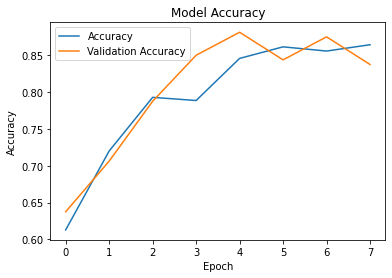

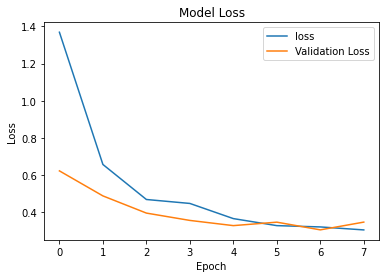

In [ ]:
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["loss","Validation Loss"])
plt.show()

In [ ]:
test_generator.reset()

In [ ]:
pred = model.predict_generator(test_generator,verbose=1,steps=test_generator.samples/batch_size)
print(pred[0:10])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


7/7 [==============================] - 125s 17s/step
[[4.1074830e-04 9.9958926e-01]
 [9.2408453e-10 9.9999994e-01]
 [9.7129405e-01 2.8706003e-02]
 [9.9535400e-01 4.6460805e-03]
 [2.1592246e-06 9.9999779e-01]
 [9.8438543e-01 1.5614517e-02]
 [2.6803914e-07 9.9999970e-01]
 [2.9314588e-06 9.9999696e-01]
 [9.8758016e-04 9.9901229e-01]
 [9.0023779e-05 9.9990994e-01]]


In [ ]:
predicted_class_idx=np.argmax(pred,axis=1)

## print the same 10 rows

print(predicted_class_idx[0:10])

[1 1 0 0 1 0 1 1 1 1]


In [ ]:
print(len(predicted_class_idx))

229


In [ ]:
model.evaluate(test_generator,use_multiprocessing=True,workers=10)

8/8 [==============================] - 137s 15s/step - loss: 0.2425 - accuracy: 0.9170


[0.24246367812156677, 0.9170305728912354]

In [ ]:
valid_generator.class_indices.items()

dict_items([('cataract', 0), ('normal', 1)])

In [ ]:
valid_labels = dict((value,key) for key,value in valid_generator.class_indices.items())
pred_labels = [valid_labels[key] for key in predicted_class_idx]
pred_labels[1:10]

['normal',
 'cataract',
 'cataract',
 'normal',
 'cataract',
 'normal',
 'normal',
 'normal',
 'normal']

In [ ]:
filenames = test_generator.filenames
prediction_df = pd.DataFrame({'Filename': filenames,'Prediction': pred_labels})
prediction_df.head()

,Filename,Prediction
0,2074_right.jpg,normal
1,3227_left.jpg,normal
2,2159_left.jpg,cataract
3,2176_right.jpg,cataract
4,2596_left.jpg,normal


In [ ]:
prediction_df.iloc[35]

Filename      2116_left.jpg
Prediction         cataract
Name: 35, dtype: object

In [ ]:
print(test_generator.filenames[35])
print(test_generator.labels[35])

2116_left.jpg
0


In [ ]:
print('Classification Report')
target_names = ['Cataract', 'Normal']
print(classification_report(test_generator.classes, predicted_class_idx, target_names=target_names))

In [ ]:
cm = confusion_matrix(test_generator.labels, predicted_class_idx)
print('Confusion Matrix')
cm

In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
cm_plot_labels = ['cataract','normal']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')